In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

DATA_DIR = "data"
DATA_FILE = "data.csv"

sns.set()

In [2]:
df = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE))
df = df.rename(columns={"data_file": "Dataset", "rank": "Rank", "estimator": "Estimator"})
df.Dataset = df.Dataset.map({"oa": "OA", "movers": "Movers"})
df.Estimator = df.Estimator.apply(lambda x: x.capitalize())
max_rank = df.Rank.max()
df["Rank"] = df.Rank.apply(lambda x: max_rank - x)
df.head()

,Rank,true_value,params,ppf025,ppf975,sim_no,Estimator,Dataset
0,49,-0.391,-0.413773,-0.631329,-0.196217,0,Conventional,Movers
1,48,-0.278,-0.367680,-0.573476,-0.161884,0,Conventional,Movers
2,47,-0.206,-0.348528,-0.540604,-0.156451,0,Conventional,Movers
3,46,-0.189,-0.261350,-0.396588,-0.126113,0,Conventional,Movers
4,45,-0.138,-0.254026,-0.387304,-0.120749,0,Conventional,Movers


In [3]:
df["Coverage"] = ((df.ppf025 <= df.true_value) & (df.true_value <= df.ppf975))
df["Probability bias"] = (df.params > df.true_value).astype(int) - .5
df["Length CI"] = df.ppf975 - df.ppf025
df["Error"] = df.params - df.true_value
df["Absolute error"] = abs(df.params - df.true_value)
df.head()

,Rank,true_value,params,ppf025,ppf975,sim_no,Estimator,Dataset,Coverage,Probability bias,Length CI,Error,Absolute error
0,49,-0.391,-0.413773,-0.631329,-0.196217,0,Conventional,Movers,True,-0.5,0.435112,-0.022773,0.022773
1,48,-0.278,-0.367680,-0.573476,-0.161884,0,Conventional,Movers,True,-0.5,0.411592,-0.089680,0.089680
2,47,-0.206,-0.348528,-0.540604,-0.156451,0,Conventional,Movers,True,-0.5,0.384153,-0.142528,0.142528
3,46,-0.189,-0.261350,-0.396588,-0.126113,0,Conventional,Movers,True,-0.5,0.270475,-0.072350,0.072350
4,45,-0.138,-0.254026,-0.387304,-0.120749,0,Conventional,Movers,True,-0.5,0.266555,-0.116026,0.116026


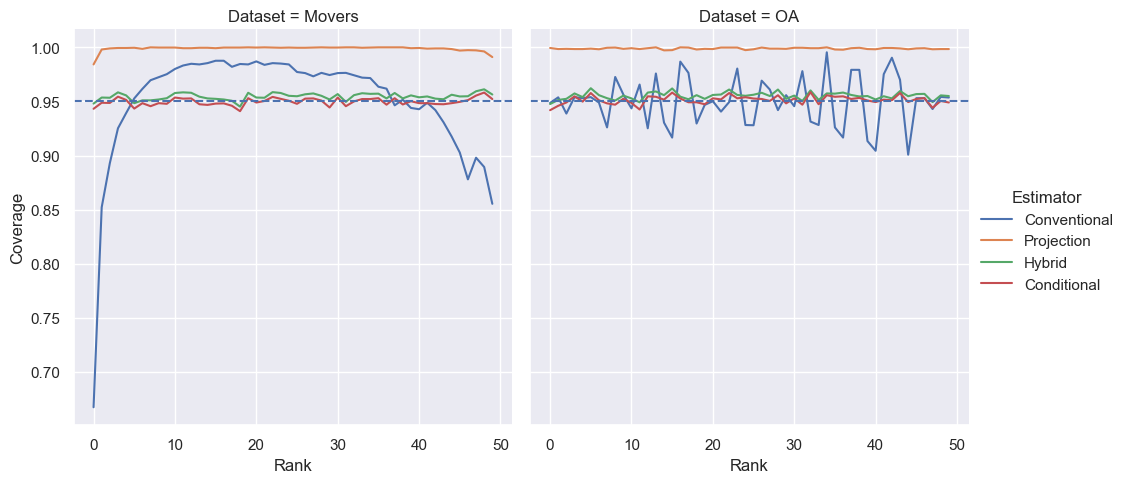

In [4]:
grid = sns.relplot(data=df, x="Rank", y="Coverage", hue="Estimator", ci=None, kind="line", col="Dataset")
for ax in grid.axes[0]:
    ax.axhline(.95, linestyle="--")
grid.fig.savefig("plots/coverage.png")
plt.show()

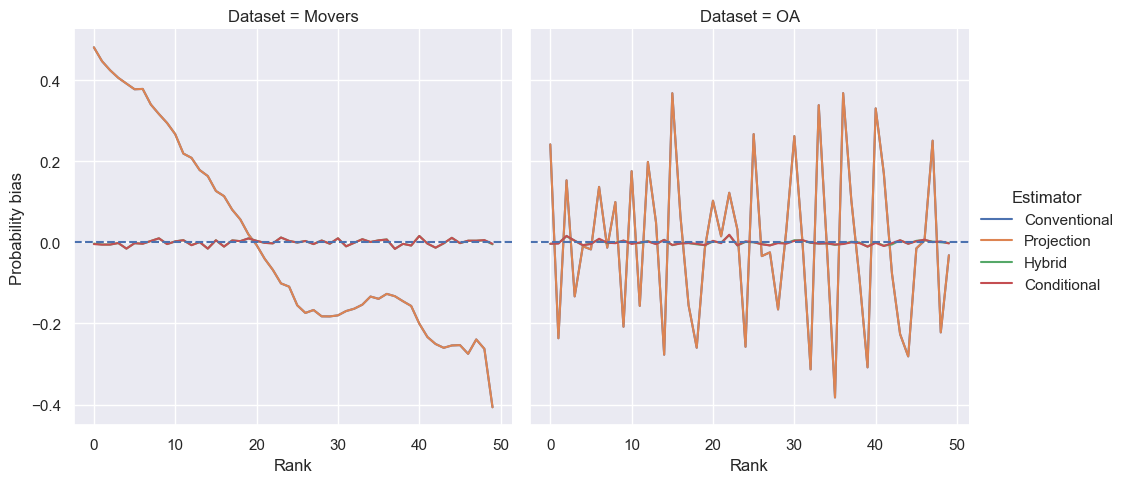

In [5]:
grid = sns.relplot(data=df, x="Rank", y="Probability bias", hue="Estimator", ci=None, kind="line", col="Dataset")
for ax in grid.axes[0]:
    ax.axhline(0, linestyle="--")
grid.fig.savefig("plots/probability_bias.png")
plt.show()

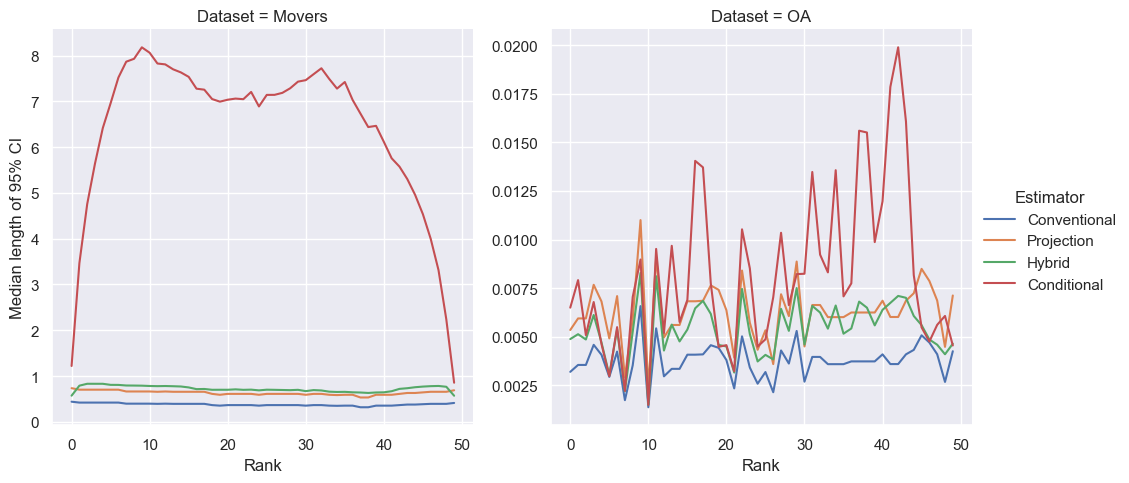

In [6]:
grid = sns.relplot(
    data=df,
    x="Rank",
    y="Length CI",
    hue="Estimator",
    ci=None,
    estimator=lambda x: np.quantile(x, .5),
    kind="line",
    col="Dataset",
    facet_kws={"sharey": False}
)
grid.set_ylabels("Median length of 95% CI")
grid.fig.savefig("plots/median_95_ci.png")
plt.show()

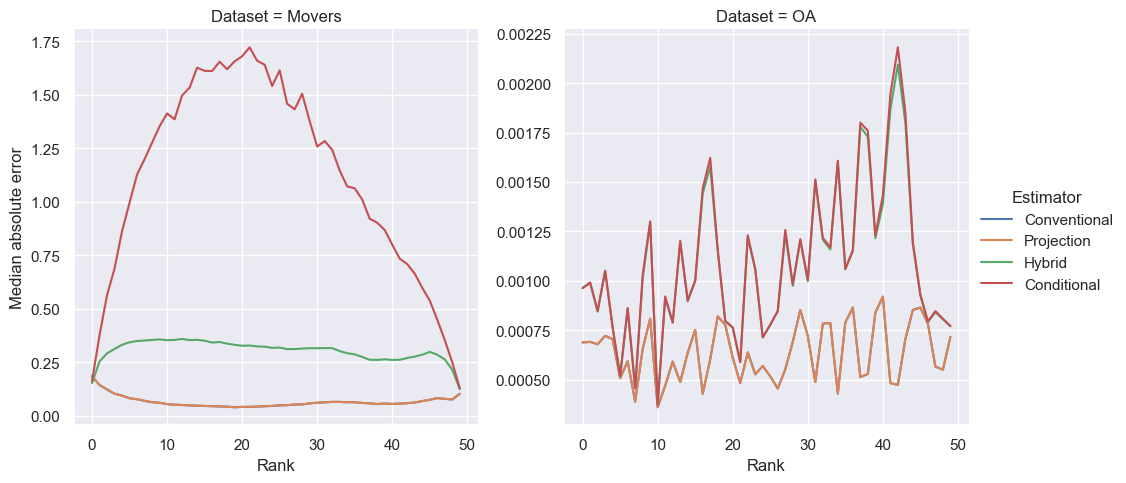

In [7]:
grid = sns.relplot(
    data=df,
    x="Rank",
    y="Absolute error",
    hue="Estimator",
    ci=None,
    estimator=lambda x: np.quantile(x, .5),
    kind="line",
    col="Dataset",
    facet_kws={"sharey": False}
)
grid.set_ylabels("Median absolute error", clear_inner=False)
grid.fig.savefig("plots/median_abs_error.png")
plt.show()

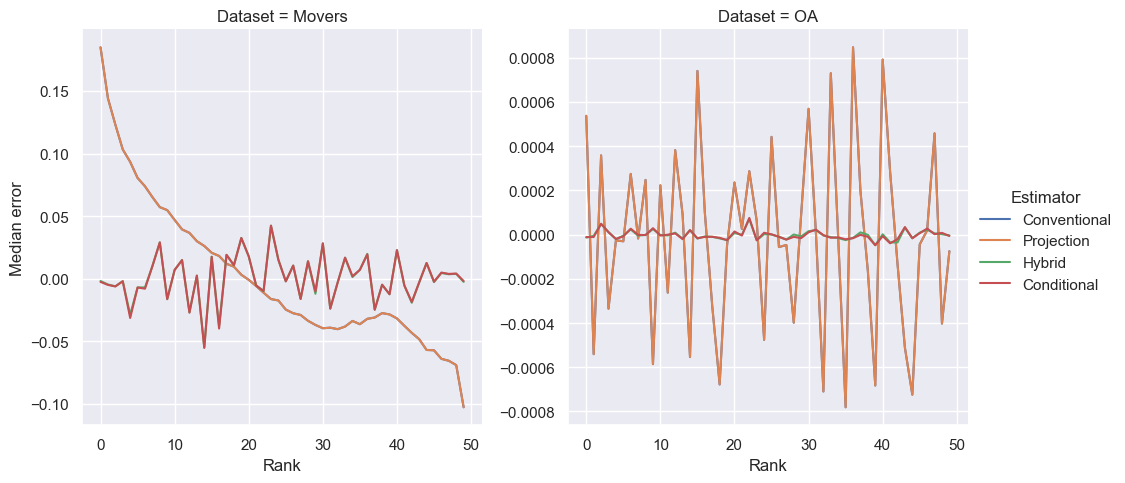

In [8]:
grid = sns.relplot(
    data=df,
    x="Rank",
    y="Error",
    hue="Estimator",
    ci=None,
    estimator=lambda x: np.quantile(x, .5),
    kind="line",
    col="Dataset",
    facet_kws={"sharey": False}
)
grid.set_ylabels("Median error", clear_inner=False)
grid.fig.savefig("plots/median_error.png")
plt.show()

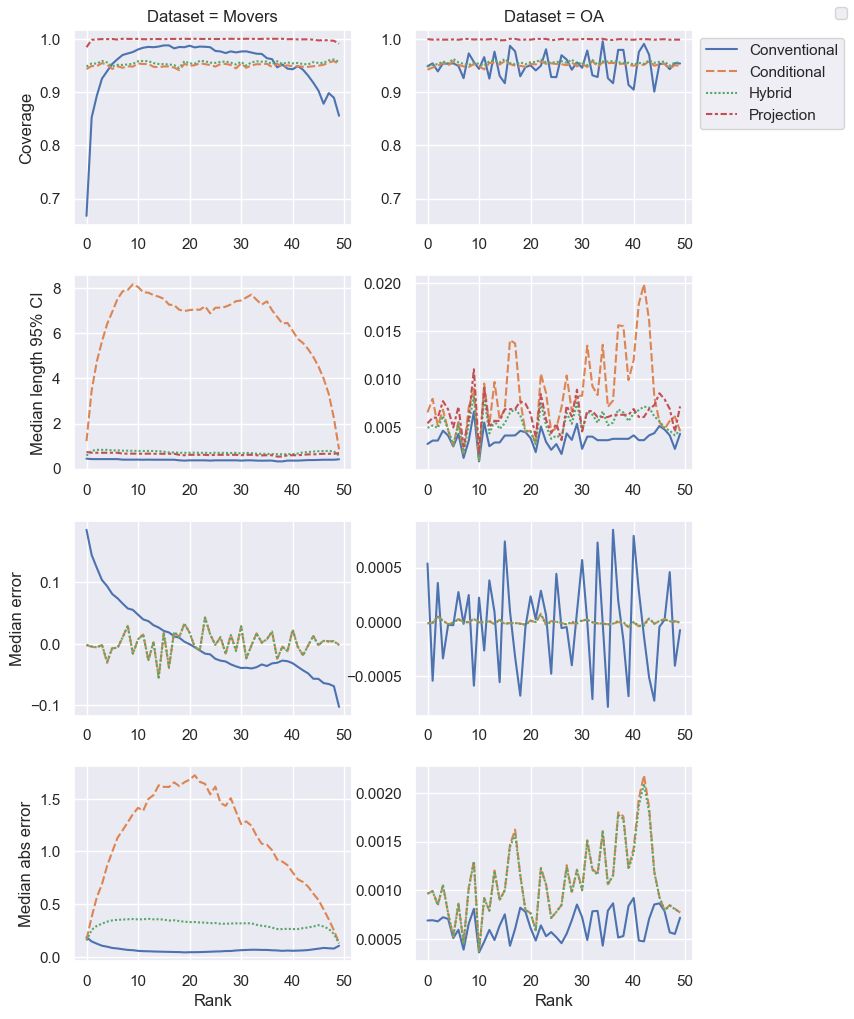

In [9]:
def add_row(row_number, y, share_y=False, include_projection=True, estimator=lambda x: x.mean(), y_label=None):
    kwargs = {
        "x": "Rank",
        "hue": "Estimator",
        "hue_order": ["Conventional", "Conditional", "Hybrid", "Projection"],
        "style": "Estimator",
        "style_order": ["Conventional", "Conditional", "Hybrid", "Projection"],
        "dashes": True,
        "ci": None,
        "legend": False,
        "estimator": estimator
    }

    df = movers_df if include_projection else movers_df[movers_df.Estimator != "Projection"]
    movers_ax = sns.lineplot(data=df, y=y, ax=axes[row_number][0], **kwargs)
    if row_number == 0:
        kwargs["legend"] = True

    df = oa_df if include_projection else oa_df[oa_df.Estimator != "Projection"]
    oa_ax = sns.lineplot(data=df, y=y, ax=axes[row_number][1], **kwargs)
    oa_ax.set_ylabel(None)
    if row_number == 0:
        oa_ax.legend(bbox_to_anchor=(1,1), loc="upper left")

    if y_label:
        movers_ax.set_ylabel(y_label)

    if share_y:
        movers_ylim, oa_ylim = movers_ax.get_ylim(), oa_ax.get_ylim()
        ylim = min(movers_ylim[0], oa_ylim[0]), max(movers_ylim[1], oa_ylim[1])
        movers_ax.set_ylim(ylim)
        oa_ax.set_ylim(ylim)

    if row_number == 0:
        movers_ax.set_title("Dataset = Movers")
        oa_ax.set_title("Dataset = OA")

    if row_number < len(rows) - 1:
        movers_ax.set_xlabel(None)
        oa_ax.set_xlabel(None)

movers, oa = tuple(df.groupby("Dataset"))
movers_df, oa_df = movers[1], oa[1]

rows = [
    ("Coverage", {"share_y": True}),
    ("Length CI", {"estimator": lambda x: np.quantile(x, .5), "y_label": "Median length 95% CI"}),
    ("Error", {"include_projection": False, "estimator": lambda x: np.quantile(x, .5), "y_label": "Median error"}),
    ("Absolute error", {"include_projection": False, "estimator": lambda x: np.quantile(x, .5), "y_label": "Median abs error"})
]

fig, axes = plt.subplots(len(rows), 2, figsize=(7, 10))
fig.tight_layout()
fig.legend(df.Estimator.unique())

for i, (y, kwargs) in enumerate(rows):
    add_row(i, y, **kwargs)

fig.savefig("plots/combined.png", bbox_inches="tight")
plt.show()